In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from casadi import *

## Ejercicio 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      284
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:      124
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      124
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

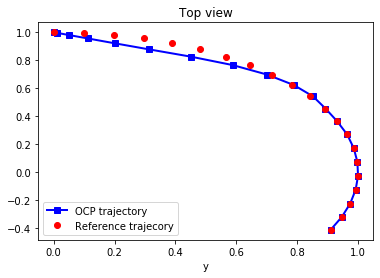

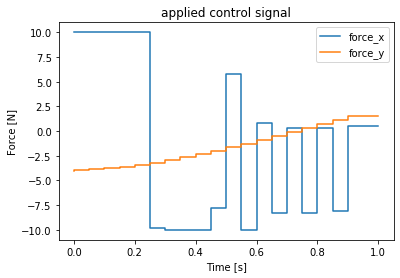

In [3]:
 
# Physical constants
 
T = 1.0 # control horizon [s]
N = 20 # Number of control intervals
 
dt = T/N # length of 1 control interval [s]
 
tgrid = np.linspace(0,T,N+1)
 
##
# ----------------------------------
#    continuous system dot(x)=f(x,u)
# ----------------------------------
nx = 4
 
# Construct a CasADi function for the ODE right-hand side
x = MX.sym('x',nx) # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u',2) # control force [N]
rhs = vertcat(x[2:4],u)
 
# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])


##
# -----------------------------------
#    Discrete system x_next = F(x,u)
# -----------------------------------
 
k1 = f(x, u)
k2 = f(x + dt/2 * k1, u)
k3 = f(x + dt/2 * k2, u)
k4 = f(x + dt * k3, u)
xf = x+dt/6*(k1 +2*k2 +2*k3 +k4)
 
F = Function('F', [x, u], [xf])
 
##
# ------------------------------------------------
# Waypoints
# ------------------------------------------------
 
ref = horzcat(sin(np.linspace(0,2,N+1)),cos(np.linspace(0,2,N+1))).T
 
##
# -----------------------------------------------
#    Optimal control problem, multiple shooting
# -----------------------------------------------
 
opti = casadi.Opti()
 
# Decision variables for states
X = opti.variable(nx,N+1)
# Decision variables for control vector
U =  opti.variable(2,N) # force [N]
 
# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:,k+1]==F(X[:,k],U[:,k]))

# Path constraints
opti.subject_to(opti.bounded(-3,X[0,:],3)) # pos_x limits
opti.subject_to(opti.bounded(-3,X[1,:],3)) # pos_y limits
opti.subject_to(opti.bounded(-3,X[2,:],3)) # vel_x limits
opti.subject_to(opti.bounded(-3,X[3,:],3)) # vel_y limits
opti.subject_to(opti.bounded(-10,U[0,:],10)) # force_x limits
opti.subject_to(opti.bounded(-10,U[1,:],10)) # force_x limits
 
# Initial constraints
opti.subject_to(X[:,0]==vertcat(ref[:,0],0,0))
 
# Try to follow the waypoints
opti.minimize(sumsqr(X[:2,:]-ref))
 
opti.solver('ipopt')
 
sol = opti.solve()
 
##
# -----------------------------------------------
#    Post-processing: plotting
# -----------------------------------------------
 
xsol = sol.value(X)
usol = sol.value(U)
 
pl.figure()
pl.plot(xsol[0,:].T,xsol[1,:].T,'bs-',linewidth=2)
pl.plot(ref[0,:].T,ref[1,:].T,'ro',linewidth=3)
pl.legend(('OCP trajectory','Reference trajecory'))
pl.title('Top view')
pl.xlabel('x')
pl.xlabel('y')
pl.figure()
pl.step(tgrid,horzcat(usol,usol[:,-1]).T)
pl.title('applied control signal')
pl.legend(('force_x','force_y'))
pl.ylabel('Force [N]')
pl.xlabel('Time [s]')
pl.show()

-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                             124
Number of constraints:                           208
Number of nonzeros in constraint Jacobian:       368
Number of nonzeros in Lagrangian Hessian:         42

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls
   0   2.100000e+01  1.00e+00  2.00e+00  0.00e+00       -  0


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   2.981543e-07   |   REM BND   81   |   123   |     0   
       1   |   4.494391e-11   |   REM BND   80   |   122   |     0   
       2   |   1.362954e-10   |   REM BND   77   |   121   |     0   
       3   |   4.529147e-11   |   REM BND   76   |   120   |     0   
       4   |   1.373061e-10   |   REM BND   73   |   119   |     0   
       5

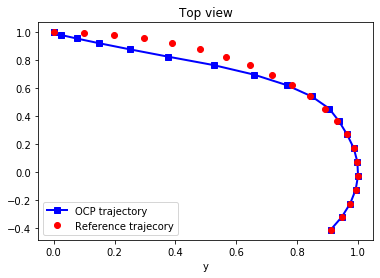

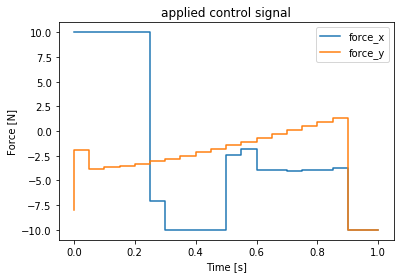

In [5]:
 
# Physical constants
 
T = 1.0 # control horizon [s]
N = 20 # Number of control intervals
 
dt = T/N # length of 1 control interval [s]
 
tgrid = np.linspace(0,T,N+1)
 
##
# ----------------------------------
#    continuous system dot(x)=f(x,u)
# ----------------------------------
nx = 4
 
# Construct a CasADi function for the ODE right-hand side
x = MX.sym('x',nx) # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u',2) # control force [N]
rhs = vertcat(x[2:4],u)
 
# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])


##
# -----------------------------------
#    Discrete system x_next = F(x,u)
# -----------------------------------
 
k1 = f(x, u)
k2 = f(x + dt/2 * k1, u)
k3 = f(x + dt/2 * k2, u)
k4 = f(x + dt * k3, u)
xf = x+dt/6*(k1 +2*k2 +2*k3 +k4)
x_newt = x + dt*k1
 
F = Function('F', [x, u], [xf])
F_newton = Function('F', [x, u], [x_newt])
 
##
# ------------------------------------------------
# Waypoints
# ------------------------------------------------
 
ref = horzcat(sin(np.linspace(0,2,N+1)),cos(np.linspace(0,2,N+1))).T
 
##
# -----------------------------------------------
#    Optimal control problem, multiple shooting
# -----------------------------------------------
 
opti = casadi.Opti()
 
# Decision variables for states
X = opti.variable(nx,N+1)
# Decision variables for control vector
U =  opti.variable(2,N) # force [N]
 
# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:,k+1]==F_newton(X[:,k],U[:,k]))

# Path constraints
opti.subject_to(opti.bounded(-3,X[0,:],3)) # pos_x limits
opti.subject_to(opti.bounded(-3,X[1,:],3)) # pos_y limits
opti.subject_to(opti.bounded(-3,X[2,:],3)) # vel_x limits
opti.subject_to(opti.bounded(-3,X[3,:],3)) # vel_y limits
opti.subject_to(opti.bounded(-10,U[0,:],10)) # force_x limits
opti.subject_to(opti.bounded(-10,U[1,:],10)) # force_x limits
 
# Initial constraints
opti.subject_to(X[:,0]==vertcat(ref[:,0],0,0))
 
# Try to follow the waypoints
opti.minimize(sumsqr(X[:2,:]-ref))
 
#opti.solver('ipopt') 
opti.solver('sqpmethod')
 
sol = opti.solve()
 
##
# -----------------------------------------------
#    Post-processing: plotting
# -----------------------------------------------
 
xsol = sol.value(X)
usol = sol.value(U)
 
pl.figure()
pl.plot(xsol[0,:].T,xsol[1,:].T,'bs-',linewidth=2)
pl.plot(ref[0,:].T,ref[1,:].T,'ro',linewidth=3)
pl.legend(('OCP trajectory','Reference trajecory'))
pl.title('Top view')
pl.xlabel('x')
pl.xlabel('y')
pl.figure()
pl.step(tgrid,horzcat(usol,usol[:,-1]).T)
pl.title('applied control signal')
pl.legend(('force_x','force_y'))
pl.ylabel('Force [N]')
pl.xlabel('Time [s]')
pl.show()

-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                             125
Number of constraints:                           209
Number of nonzeros in constraint Jacobian:       449
Number of nonzeros in Lagrangian Hessian:        202

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls
   0   2.100000e+01  1.00e+00  2.00e+00  0.00e+00       -  0


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   2.981185e-07   |   REM BND   81   |   124   |     0   
       1   |   4.465759e-11   |   REM BND   80   |   123   |     0   
       2   |   1.354308e-10   |   REM BND   77   |   122   |     0   
       3   |   4.500114e-11   |   REM BND   76   |   121   |     0   
       4   |   1.364293e-10   |   REM BND   73   |   120   |     0   
       5

     363   |   2.616293e-01   |   REM CON  181   |     0   |    99   
     364   |   1.524774e-03   |   REM CON   38   |     0   |    98   
     365   |   5.035317e-04   |   ADD CON   38   |     0   |    99   
     366   |   6.327887e-01   |   REM CON  202   |     0   |    98   
     367   |   3.991871e-01   |   REM CON  208   |     0   |    97   
     368   |   2.207767e-04   |   ADD CON  208   |     0   |    98   
     369   |   2.331243e-02   |   REM CON   42   |     0   |    97   
     370   |   1.924602e-04   |   ADD CON   42   |     0   |    98   
     371   |   4.528064e-02   |   REM CON  182   |     0   |    97   
     372   |   1.000000e+00   |   REM CON   29   |     0   |    97   
   1   2.530909e-01  2.50e-01  1.07e+00  1.00e+01       -  1


####################   qpOASES  --  QP NO.   2   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   2.240361

      76   |   6.880157e-03   |   REM CON    6   |     0   |   100   
      77   |   2.758556e-02   |   ADD CON    6   |     0   |   101   
      78   |   2.332356e-03   |   ADD CON   50   |     0   |   102   
      79   |   5.128193e-02   |   ADD CON   14   |     0   |   103   
      80   |   3.811012e-02   |   REM CON   10   |     0   |   102   
      81   |   7.120286e-02   |   ADD CON   60   |     0   |   103   
      82   |   1.720763e-02   |   ADD CON   10   |     0   |   104   
      83   |   2.061683e-01   |   REM CON   26   |     0   |   103   
      84   |   7.186545e-02   |   ADD CON   26   |     0   |   104   
      85   |   1.009148e-01   |   REM CON   46   |     0   |   103   
      86   |   4.956124e-02   |   ADD CON   46   |     0   |   104   
      87   |   2.915490e-01   |   REM CON   30   |     0   |   103   
      88   |   4.273110e-02   |   ADD CON   30   |     0   |   104   
      89   |   4.905285e-01   |   REM CON   16   |     0   |   103   
      90   |   3.072

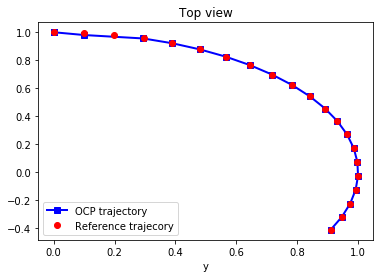

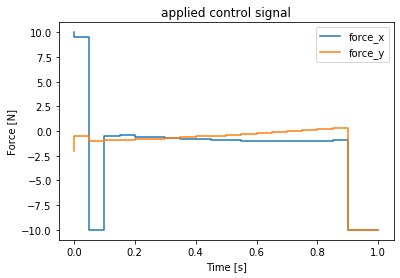

In [6]:
 
# Physical constants
 
#T = 1.0 # control horizon [s]
N = 20 # Number of control intervals
 
dt = MX.sym('dt')# length of 1 control interval [s]
 
tgrid = np.linspace(0,T,N+1)
 
##
# ----------------------------------
#    continuous system dot(x)=f(x,u)
# ----------------------------------
nx = 4
 
# Construct a CasADi function for the ODE right-hand side
x = MX.sym('x',nx) # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u',2) # control force [N]
rhs = vertcat(x[2:4],u)
 
# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])


##
# -----------------------------------
#    Discrete system x_next = F(x,u)
# -----------------------------------
 
k1 = f(x, u)
k2 = f(x + dt/2 * k1, u)
k3 = f(x + dt/2 * k2, u)
k4 = f(x + dt * k3, u)
xf = x+dt/6*(k1 +2*k2 +2*k3 +k4)
x_newt = x + dt*k1
 
F = Function('F', [x, u, dt], [xf])
F_newton = Function('F', [x, u, dt], [x_newt])
 
##
# ------------------------------------------------
# Waypoints
# ------------------------------------------------
 
ref = horzcat(sin(np.linspace(0,2,N+1)),cos(np.linspace(0,2,N+1))).T
 
##
# -----------------------------------------------
#    Optimal control problem, multiple shooting
# -----------------------------------------------
 
opti = casadi.Opti()
 
# Decision variables for states
X = opti.variable(nx,N+1)
# Decision variables for control vector
U =  opti.variable(2,N) # force [N]
T =  opti.variable() # Time [s]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:,k+1]==F_newton(X[:,k],U[:,k], T/N))

# Path constraints
opti.subject_to(opti.bounded(-3,X[0,:],3)) # pos_x limits
opti.subject_to(opti.bounded(-3,X[1,:],3)) # pos_y limits
opti.subject_to(opti.bounded(-3,X[2,:],3)) # vel_x limits
opti.subject_to(opti.bounded(-3,X[3,:],3)) # vel_y limits
opti.subject_to(opti.bounded(-10,U[0,:],10)) # force_x limits
opti.subject_to(opti.bounded(-10,U[1,:],10)) # force_x limits
 
# Time is bounded
opti.subject_to(opti.bounded(0.5,T,2))
opti.set_initial(T, 1)

# Initial constraints
opti.subject_to(X[:,0]==vertcat(ref[:,0],0,0))
 
# Try to follow the waypoints
opti.minimize(sumsqr(X[:2,:]-ref))
 
#opti.solver('ipopt') 
opti.solver('sqpmethod')
 
sol = opti.solve()
 
##
# -----------------------------------------------
#    Post-processing: plotting
# -----------------------------------------------
 
xsol = sol.value(X)
usol = sol.value(U)
 
pl.figure()
pl.plot(xsol[0,:].T,xsol[1,:].T,'bs-',linewidth=2)
pl.plot(ref[0,:].T,ref[1,:].T,'ro',linewidth=3)
pl.legend(('OCP trajectory','Reference trajecory'))
pl.title('Top view')
pl.xlabel('x')
pl.xlabel('y')
pl.figure()
pl.step(tgrid,horzcat(usol,usol[:,-1]).T)
pl.title('applied control signal')
pl.legend(('force_x','force_y'))
pl.ylabel('Force [N]')
pl.xlabel('Time [s]')
pl.show()

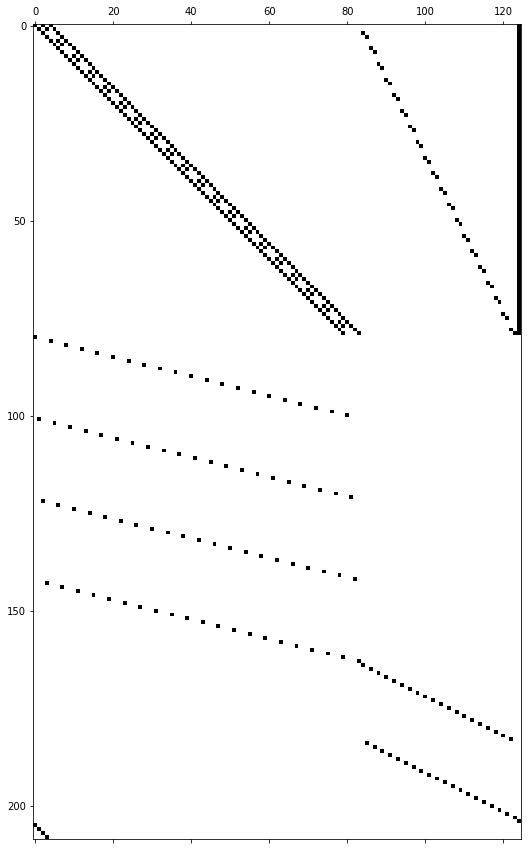

In [17]:
plt.figure(figsize=[10,15])
plt.spy(jacobian(opti.g,opti.x).sparsity())

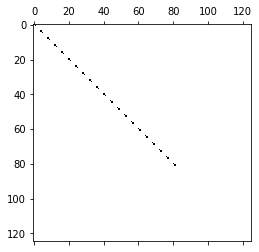

In [9]:
plt.spy(hessian(opti.f,opti.x)[0].sparsity())

## Ejercicio 10

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      322
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      241

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality constraints...............:       81
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       81
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

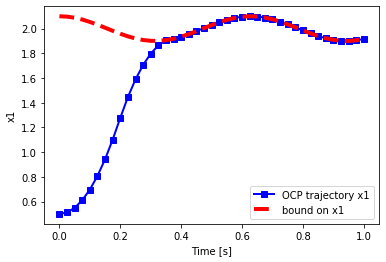

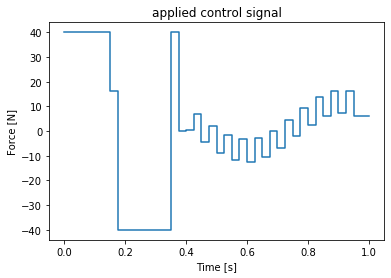

In [19]:
# Physical constants
 
T = 1.0 # control horizon [s]
N = 40 # Number of control intervals
 
dt = T/N # length of 1 control interval [s]
 
tgrid = np.linspace(0,T,N+1)
 
##
# ----------------------------------
#    continuous system dot(x)=f(x,u)
# ----------------------------------
nx = 2
 
# Construct a CasADi function for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u') # control
rhs = vertcat(x2,-0.1*(1-x1**2)*x2 - x1 + u)
x = vertcat(x1,x2)
 
x1_bound = lambda t: 2+0.1*cos(10*t)
 
##
# -----------------------------------
#    Discrete system x_next = F(x,u)
# -----------------------------------
 
opts = dict()
opts["tf"] = dt
intg = integrator('intg','cvodes',{'x':x,'p':u,'ode':rhs},opts)
 
##
# -----------------------------------------------
#    Optimal control problem, multiple shooting
# -----------------------------------------------
x0 = vertcat(0.5,0)
 
opti = casadi.Opti();
 
# Decision variable for states
x = opti.variable(nx)
 
# Initial constraints
opti.subject_to(x==x0)
 
U = []
X = [x]
# Gap-closing shooting constraints
for k in range(N):
  u = opti.variable()
  U.append(u)
 
  x_next = opti.variable(nx)
  res = intg(x0=x,p=u)
  opti.subject_to(x_next==res["xf"])
 
  opti.subject_to(opti.bounded(-40,u,40))
  opti.subject_to(opti.bounded(-0.25,x[0],x1_bound(tgrid[k])))
   
  x = x_next
  X.append(x)
 
opti.subject_to(opti.bounded(-0.25,x_next[0],x1_bound(tgrid[N])))
U = hcat(U)
X = hcat(X)
 
opti.minimize(sumsqr(X[0,:]-3))
 
opti.solver('ipopt')
 
sol = opti.solve()
 
##
# -----------------------------------------------
#    Post-processing: plotting
# -----------------------------------------------
 
 
# Simulate forward in time using an initial state and control vector
usol = sol.value(U)
xsol = sol.value(X)
 
pl.figure()
pl.plot(tgrid,xsol[0,:].T,'bs-',linewidth=2)
pl.plot(tgrid,x1_bound(tgrid),'r--',linewidth=4)
pl.legend(('OCP trajectory x1','bound on x1'))
pl.xlabel('Time [s]')
pl.ylabel('x1')
pl.figure()
print(usol.shape)
pl.step(tgrid,vertcat(usol,usol[-1]))
pl.title('applied control signal')
pl.ylabel('Force [N]')
pl.xlabel('Time [s]')
 
pl.show()

In [24]:
# Physical constants
 
T = 1.0 # control horizon [s]
N = 40 # Number of control intervals
 
dt = T/N # length of 1 control interval [s]
 
tgrid = np.linspace(0,T,N+1)
 
##
# ----------------------------------
#    continuous system dot(x)=f(x,u)
# ----------------------------------
nx = 2
 
# Construct a CasADi function for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u') # control
 
P = MX.sym('x',2,2) #Covariance Matrix
rhs = vertcat(x2,-0.1*(1-x1**2)*x2 - x1 + u)
x = vertcat(x1,x2)
 
A = jacobian(rhs,x)
B = jacobian(rhs,u)
 
x = vertcat(x,vec(P))
dotP = A @ P+P @ A.T
 
rhs = vertcat(rhs,vec(dotP))
 
x1_bound = lambda t: 2+0.1*cos(10*t)
 
##
# -----------------------------------
#    Discrete system x_next = F(x,u)
# -----------------------------------
 
opts = dict()
opts["tf"] = dt
intg = integrator('intg','cvodes',{'x':x,'p':u,'ode':rhs},opts)
 
##
# -----------------------------------------------
#    Optimal control problem, multiple shooting
# -----------------------------------------------
x0 = vertcat(0.5,0)
 
opti = casadi.Opti();
 
# Decision variable for states
x = opti.variable(nx)
P = opti.variable(nx,nx)
 
# Initial constraints
opti.subject_to(x==x0)
opti.subject_to(P==diag([0.01**2,0.1**2]))
 
U = []
X = [x]
Ps = [P]
# Gap-closing shooting constraints
for k in range(N):
    u = opti.variable()
    U.append(u)

    x_next = opti.variable(nx)
    P_next = opti.variable(nx,nx)
    res = intg(x0=vertcat(x,vec(P)),p=u)

    xf = res["xf"][:nx]
    Pf = reshape(res["xf"][nx:],nx,nx)
    opti.subject_to(x_next==xf)
    opti.subject_to(vec(P_next)==vec(Pf))

    opti.subject_to(opti.bounded(-40,u,40))
    opti.subject_to(opti.bounded(-0.25,x[0],x1_bound(tgrid[k])))

    x = x_next
    P = P_next

    Ps.append(P)
    X.append(x)

opti.subject_to(opti.bounded(-0.25,x_next[0],x1_bound(tgrid[N])))
U = hcat(U)
X = hcat(X)
 
opti.minimize(sumsqr(X[0,:]-3))
 
opti.solver('ipopt')
 
sol = opti.solve()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1606
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      721

Total number of variables............................:      286
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:       81
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       81
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

[[0.0094851  0.00731403]
 [0.00731403 0.00580253]]
(2, 41)


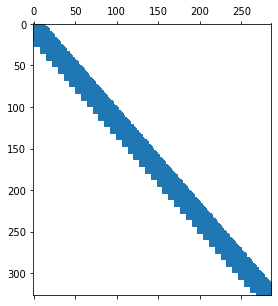

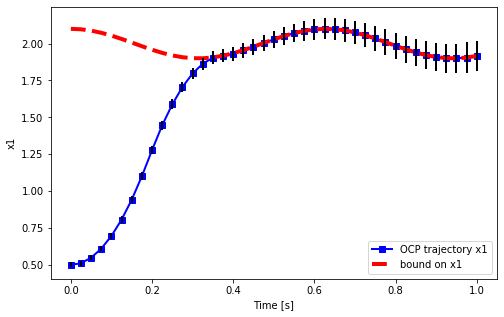

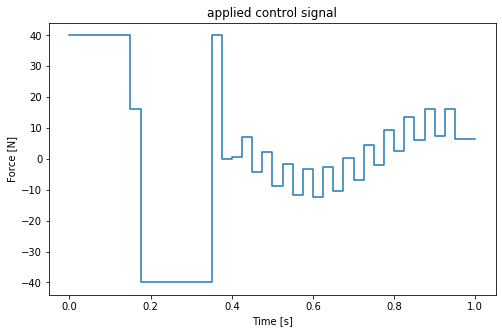

In [30]:
pl.figure(figsize=[8,5])
pl.spy(sol.value(jacobian(opti.g,opti.x)))
 
print(sol.value(Ps[-1]))
 
##
# -----------------------------------------------
#    Post-processing: plotting
# -----------------------------------------------
 
 
# Simulate forward in time using an initial state and control vector
usol = sol.value(U)
xsol = sol.value(X)
 
print(xsol.shape)
pl.figure(figsize=[8,5])
pl.plot(tgrid,xsol[0,:].T,'bs-',linewidth=2)
pl.plot(tgrid,x1_bound(tgrid),'r--',linewidth=4)
 
for k in range(N+1):
  var = sol.value(horzcat(1,0) @ Ps[k] @ vertcat(1,0))
  sigma = sqrt(var)
  t = tgrid[k]
  pl.plot([t,t],[xsol[0,k]-sigma,xsol[0,k]+sigma],'k',linewidth=2)
 
pl.legend(('OCP trajectory x1','bound on x1'))
pl.xlabel('Time [s]')
pl.ylabel('x1')
pl.figure(figsize=[8,5])
pl.step(tgrid,vertcat(usol,usol[-1]))
pl.title('applied control signal')
pl.ylabel('Force [N]')
pl.xlabel('Time [s]')
 
pl.show()